<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Demo_batch_tfms_TPU_performance_diff_debug_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### [RUNME] Install Colab compatible PyTorch/XLA wheels and dependencies
This may take up to ~2 minutes



In [ ]:
VERSION = "20200516"  #@param ["1.5" , "20200516", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  61626      0 --:--:-- --:--:-- --:--:-- 61626
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200516 ...
     |████████████████████████████████| 61kB 2.5MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200516-cp36-cp36m-linux_x86_64.whl...
\ [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     


In [ ]:
!pip install fastai2 --upgrade > /dev/null
!pip freeze | grep fastai2

fastai2==0.0.17


In [ ]:
!pip install git+https://github.com/butchland/fastai_xla_extensions > /dev/null
!pip freeze | grep fastai_xla_extensions

  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-mh5077d7


In [ ]:
import fastai_xla_extensions.core

In [ ]:
from fastai2.vision.all import *

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
Path.BASE_PATH = path; path.ls()

(#2) [Path('training'),Path('testing')]

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(train_name='training',valid_name='testing'),
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [ ]:
datablock_tfms= datablock.new(batch_tfms=[*aug_transforms(size=28, do_flip=False), Normalize],item_tfms=Resize(40))

In [ ]:
datablock_tfms.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> Normalize

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying R

In [ ]:
dls1 = datablock_tfms.dataloaders(path,bs=256)
dls1.device

device(type='xla', index=1)

In [ ]:
learn1 = cnn_learner(dls1, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
learn1.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.571644,0.909826,0.715700,02:06
1,0.988431,0.603125,0.806000,02:05
2,0.655336,0.407106,0.864000,01:36
3,0.452211,0.275844,0.912600,01:36


In [ ]:
datablock_no_tfms= datablock.new(batch_tfms=[],item_tfms=Resize(28))

In [ ]:
datablock_no_tfms.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying Resize gives
      (PILImage mode=RGB size=28x2

In [ ]:
dls2 = datablock_no_tfms.dataloaders(path,bs=256)
dls2.device

device(type='xla', index=1)

In [ ]:
learn2 = cnn_learner(dls2, resnet18, metrics=accuracy)

In [ ]:
learn2.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.443302,0.865859,0.730000,01:51
1,0.878908,0.581814,0.814500,01:25
2,0.551731,0.378798,0.878700,01:26
3,0.371268,0.261603,0.916700,01:26


Add Normalize to empty batch transforms

In [ ]:
datablock_tfms_norm_only = datablock.new(item_tfms=Resize(28), batch_tfms=[Normalize])

In [ ]:
datablock_tfms_norm_only.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> Normalize

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying Resize gives
      (PILImage mode=

In [ ]:
dls3 = datablock_tfms_norm_only.dataloaders(path, bs=256)
dls3.device

device(type='xla', index=1)

In [ ]:
learn3 = cnn_learner(dls3, resnet18, metrics=accuracy)

In [ ]:
learn3.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.419888,0.883360,0.726900,01:32
1,0.845393,0.575396,0.818500,01:25
2,0.538643,0.390274,0.872400,01:24
3,0.371201,0.275787,0.911500,01:24


Normalize doesnt seem to slow it down.

In [ ]:
batch_tfms = [*aug_transforms(size=28, do_flip=False)]

In [ ]:
len(batch_tfms)

2

In [ ]:
batch_tfms

[AffineCoordTfm: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ,
 LightingTfm: (TensorImage,object) -> encodes ]

In [ ]:
no_affine_tfms = [batch_tfms[1],Normalize]

In [ ]:
no_affine_tfms

[LightingTfm: (TensorImage,object) -> encodes ,
 fastai2.data.transforms.Normalize]

In [ ]:
datablock_no_affine_tfms = datablock.new(item_tfms=Resize(28), batch_tfms=no_affine_tfms)

In [ ]:
datablock_no_affine_tfms.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> LightingTfm -> Normalize

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying Resize gives
      

In [ ]:
dls4 = datablock_no_affine_tfms.dataloaders(path, bs=256)
dls4.device

device(type='xla', index=1)

In [ ]:
learn4 = cnn_learner(dls4, resnet18, metrics=accuracy)

In [ ]:
learn4.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.428789,0.870235,0.727900,01:44
1,0.861603,0.564166,0.820700,01:37
2,0.540606,0.390945,0.874900,01:26
3,0.371852,0.266826,0.910500,01:26


In [ ]:
datablock_affine_only_tfms = datablock.new(item_tfms=Resize(40), batch_tfms=[batch_tfms[0]])

In [ ]:
datablock_affine_only_tfms.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying Resize gives
      (PILImage 

In [ ]:
dls5 = datablock_affine_only_tfms.dataloaders(path, bs=256)
dls5.device

device(type='xla', index=1)

In [ ]:
learn5 = cnn_learner(dls5, resnet18, metrics=accuracy)

In [ ]:
learn5.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.531065,0.877829,0.720200,02:05
1,0.967777,0.580436,0.813000,01:53
2,0.639149,0.379227,0.876600,01:39
3,0.437950,0.262171,0.913900,01:40


In [ ]:
min_aug = aug_transforms(size=28, do_flip=False, max_rotate=0.0, max_zoom=1.1,max_warp=0.)
min_aug

[AffineCoordTfm: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ,
 LightingTfm: (TensorImage,object) -> encodes ]

In [ ]:
datablock_min_affine_only = datablock.new(item_tfms=Resize(40), batch_tfms=[min_aug[0]])

In [ ]:
datablock_min_affine_only.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying Resize gives
      (PILImage 

In [ ]:
min_aug[0]

AffineCoordTfm: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes 

In [ ]:
dls6 = datablock_min_affine_only.dataloaders(path, bs=256)

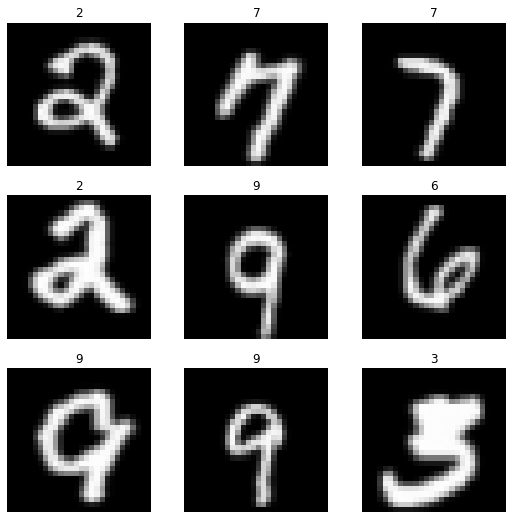

In [ ]:
dls6.show_batch()

In [ ]:
learn6 = cnn_learner(dls6, resnet18, metrics=accuracy)

In [ ]:
learn6.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.393099,0.837496,0.735300,01:55
1,0.822208,0.554914,0.821900,01:36
2,0.528956,0.357311,0.884600,01:36
3,0.365569,0.242920,0.921600,01:36


In [ ]:
light_only_aug_tfms = aug_transforms(size=28, do_flip=False, max_rotate=0, max_zoom=1.0, max_warp=0.)

In [ ]:
light_only_aug_tfms

[LightingTfm: (TensorImage,object) -> encodes ]

In [ ]:
datablock_light_only_tfms = datablock.new(item_tfms=Resize(28), batch_tfms=light_only_aug_tfms)

In [ ]:
datablock_light_only_tfms.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying Resize gives
      (PILImage mod

In [ ]:
dls7 = datablock_light_only_tfms.dataloaders(path, bs=256)

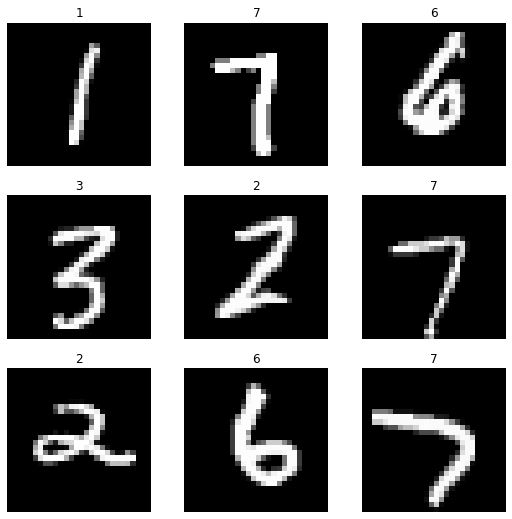

In [ ]:
dls7.show_batch()

In [ ]:
learn7 = cnn_learner(dls7, resnet18, metrics=accuracy)

In [ ]:
learn7.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.447988,0.857747,0.733100,01:33
1,0.875352,0.563979,0.821700,01:25
2,0.556831,0.382872,0.879900,01:26
3,0.379415,0.260477,0.916000,01:25


In [ ]:
warp_only_affine_tfms = aug_transforms(size=28, do_flip=False, max_rotate=0.0, max_zoom=1., max_lighting=0.0)
warp_only_affine_tfms

[AffineCoordTfm: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ]

In [ ]:
datablock_warp_only_affine_tfms = datablock.new(item_tfms=Resize(40), batch_tfms=warp_only_affine_tfms)

In [ ]:
datablock_warp_only_affine_tfms.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying Resize gives
      (PILImage 

In [ ]:
dls8 = datablock_warp_only_affine_tfms.dataloaders(path, bs=256)
dls8.device

device(type='xla', index=1)

In [ ]:
learn8 = cnn_learner(dls8, resnet18, metrics=accuracy)

In [ ]:
learn8.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.530683,0.848905,0.733300,01:56
1,0.940204,0.550284,0.828200,01:47
2,0.609583,0.370258,0.880400,01:38
3,0.411337,0.249669,0.918400,01:38


In [ ]:
size_only_aug_tfms = aug_transforms(size=28, do_flip=False, max_rotate=0.0, max_zoom=1.0, max_warp=0., max_lighting=0.0, min_scale=0.8)
size_only_aug_tfms

[RandomResizedCropGPU: (TensorImage,object) -> encodes ]

In [ ]:
datablock_size_only_aug_tfms = datablock.new(item_tfms=Resize(40), batch_tfms=size_only_aug_tfms)

In [ ]:
datablock_size_only_aug_tfms.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /root/.fastai/data/mnist_png/training/6/13035.png
    applying parent_label gives
      6
    applying Categorize gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(6))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> RandomResizedCropGPU

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=28x28, TensorCategory(6))
    applying Resize gives
      (PIL

In [ ]:
dls9 = datablock_size_only_aug_tfms.dataloaders(path, bs=256)
dls9.device

device(type='xla', index=1)

In [ ]:
learn9 = cnn_learner(dls9, resnet18, metrics=accuracy)

In [ ]:
learn9.fine_tune(0, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.393913,0.873277,0.721300,01:50
1,0.834082,0.584564,0.811900,01:37
2,0.536710,0.400622,0.872000,01:38
3,0.363823,0.287238,0.906000,01:37
